## Questão de negócio: encontrar casas abaixo do valor de mercado para que seja possível a realização de lucro

### Importando o dataset e trocando a coluna date para tipo datetime

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.float_format', lambda x: '%.2f' % x)

df = pd.read_csv('kc_house_data.csv')

df['date'] = pd.to_datetime(df['date'])
print(df.shape)
print(df.columns)

(21613, 21)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


## Hipótese 1: Existem casas em boas condições com valor abaixo de 50% do valor da mediana da área

### Estratégia: selecionar casas com preço abaixo da mediana de preço do respectivo zipcode (código de área) e filtrar apenas casas em boas condições.

In [26]:
median = df[['price','zipcode']].groupby('zipcode').median().reset_index()
median.rename(columns={'price':'price_median'}, inplace=True)

In [4]:
df2 = pd.merge(df, median, on=['zipcode'], how='inner')
print(df['condition'].unique())
for i in range(len(df2)):
    if (df2.loc[i,'price']< df2.loc[i,'price_median']) and (df2.loc[i,'condition']==5):
        df2.loc[i,'recommendation'] = 'buy'
    else:
        df2.loc[i,'recommendation'] = 'dont buy'


[3 5 4 1 2]


In [12]:
tobuy = df2[df2['recommendation']=='buy'][['id','zipcode','price','price_median','condition']]

### Encontrando as maiores diferenças relativas entre o preço e o preço mediano

In [13]:
tobuy['difference'] = ((tobuy['price_median']-tobuy['price'])/tobuy['price_median'])*100;
tobuy.sort_values('difference',ascending=False).head(10)

,id,zipcode,price,price_median,condition,difference
3373,5111400086,98038,110000.00,342000.00,5,67.84
10654,4337600005,98166,153000.00,390000.00,5,60.77
10072,418000310,98056,155000.00,380000.00,5,59.21
5349,1172000150,98103,238000.00,550000.00,5,56.73
10172,425200205,98056,165000.00,380000.00,5,56.58
12017,8651402750,98042,132825.00,292000.00,5,54.51
6882,3977630130,98092,146300.00,309780.00,5,52.77
18320,643300010,98006,365000.00,760184.50,5,51.99
16653,1771110090,98077,316000.00,652475.00,5,51.57
18351,2206700215,98006,375000.00,760184.50,5,50.67


## Hipótese 2: A diferença de preço mediano entre casas com 1 e 2 quartos é maior do que a diferença entre as outras quantidades de quartos

### Estratégia: tirar a média por número de quartos, depois fazer a diferença entre as médias

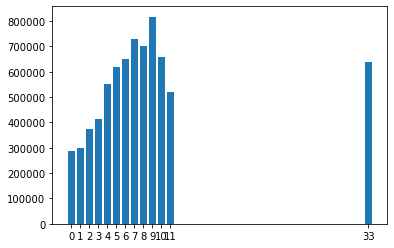

In [7]:
quartos = df[['price','bedrooms']].groupby('bedrooms').median().reset_index()



plt.bar(quartos['bedrooms'],quartos['price'])

plt.xticks(quartos['bedrooms']);


In [21]:
dif = pd.DataFrame()
for i in range(len(quartos)):
    if i == 0:
        dif.loc[i,'dif'] = 0
        dif.loc[i,'qt_quartos'] = 'De 0 para 0'
    else:
            dif.loc[i,'qt_quartos'] = 'De {} para {}'.format(quartos.loc[i-1,'bedrooms'],quartos.loc[i,'bedrooms'])
            dif.loc[i,'dif'] = quartos.loc[i,'price']-quartos.loc[i-1,'price']
dif.drop(0,inplace=True)
dif = dif.sort_values('dif',ascending=False).reset_index()
print(dif)


    index        dif     qt_quartos
0       4  136997.50    De 3 para 4
1      12  120000.00  De 11 para 33
2       9  117000.00    De 8 para 9
3       7   78580.00    De 6 para 7
4       2   75000.00    De 1 para 2
5       5   70002.50    De 4 para 5
6       3   39000.00    De 2 para 3
7       6   30000.00    De 5 para 6
8       1   11000.00    De 0 para 1
9       8  -28580.00    De 7 para 8
10     11 -140000.00  De 10 para 11
11     10 -157000.00   De 9 para 10


## Hipótese 3: Imóveis construídos até 1950 e que foram reformados tem preços 20% maiores do que os que não foram reformados, em média

### Estratégia: filtrar imóveis com ano construído menor que 1950, separar os que foram renovados e os que não foram e tirar as médias

<BarContainer object of 2 artists>

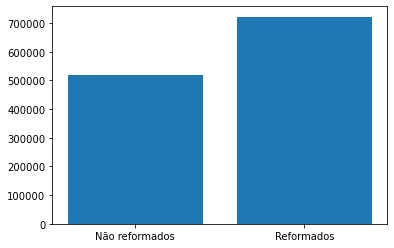

In [9]:
a_1950 = df[df['yr_built']<=1950]
aref_1950 = a_1950[a_1950['yr_renovated']!=0]['price'].mean()
nref_1950 = a_1950[a_1950['yr_renovated']==0]['price'].mean()


plt.bar(['Não reformados','Reformados'],[nref_1950,aref_1950])


## Hipótese 4: Os imóveis com vista para água se valorizam mais com o tempo

### Estratégia: fazer uma coluna apenas com o ano, agrupar com base no ano e vista pra água, plotar médias de preço com e sem vista para cada ano. 

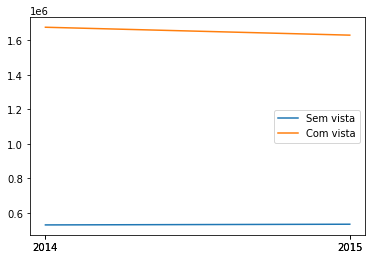

In [10]:
df['year'] = df['date'].dt.year
water = df[['price','year','waterfront']].groupby(['waterfront','year']).mean().reset_index()

plt.plot(water[water['waterfront']==0]['year'], water[water['waterfront']==0]['price'], label = "Sem vista")
plt.plot(water[water['waterfront']==1]['year'], water[water['waterfront']==1]['price'], label = "Com vista")
plt.xticks(water['year']);
plt.legend()
plt.show()

## Hipótese 5: Imóveis com porão são 20% mais caros que imóveis sem porão

### Estratégia: separar imóveis com e sem porão pela área e criar gráfico de barras

<BarContainer object of 2 artists>

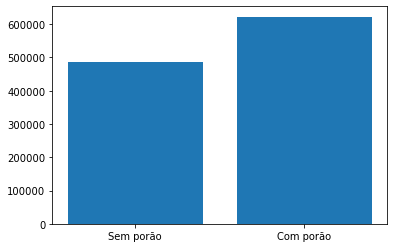

In [25]:
por = df[df['sqft_basement']>0]['price'].mean()
spor = df[df['sqft_basement']==0]['price'].mean()

plt.bar(['Sem porão','Com porão'],[spor,por])

## Hipótese 6: É possível ter diferença de preços médios de imóveis de 10% entre meses devido à sazonalidade

### Estratégia: extrair da data uma coluna de mês, criar uma nova coluna apenas com mês e ano e plotar valores médios em uma série temporal

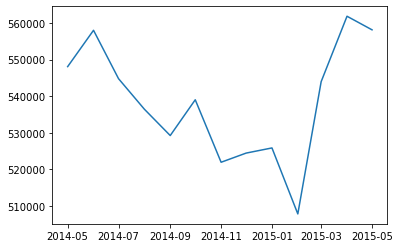

In [78]:
df['month'] = df['date'].dt.month

MoM = df[['price','month','year']].groupby(['year','month']).mean().reset_index()
MoM[['month','year']]=MoM[['month','year']].astype(str)
MoM['month/year'] = MoM['month'] + '/' + MoM['year']
MoM.drop(['year','month'],axis=1,inplace=True)
MoM['month/year'] = pd.to_datetime(MoM['month/year'],format='%m/%Y')
plt.plot(MoM['month/year'],MoM['price'])